In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from skimage.morphology import closing, square
from tools import *
from plot import *

In [2]:
indiana_img = np.load('../data/indianapines.npy')
indiana_labels = np.load('../data/indianapines_gt.npy')
salinas_img = np.load('../data/salinas.npy')
salinas_labels = np.load('../data/salinas_gt.npy')

In [3]:
# normalize radiance values to get reflectance values
indiana_img = indiana_img / indiana_img.max()
salinas_img = salinas_img / salinas_img.max()

In [4]:
print("Indiana shape: {}".format(indiana_img.shape))
print("Salinas shape: {}".format(salinas_img.shape))

Indiana shape: (145, 145, 200)
Salinas shape: (512, 217, 204)


In [5]:
X_indiana = indiana_img.reshape((-1, indiana_img.shape[-1])) # reshaping the HSI as a 2D matrix
print("Indiana shape: {}".format(X_indiana.shape))

X_salinas = salinas_img.reshape((-1, salinas_img.shape[-1])) # reshaping the HSI as a 2D matrix
print("Salinas shape: {}".format(X_salinas.shape))

Indiana shape: (21025, 200)
Salinas shape: (111104, 204)


In [6]:
n_cluster_indiana = len(np.unique(indiana_labels)) - 1
n_cluster_salinas = len(np.unique(salinas_labels)) - 1

## Remove unclassified data

In [7]:
X_indiana, X_indiana_idx = remove_unclassified_input(X_indiana, indiana_labels)
X_salinas, X_salinas_idx = remove_unclassified_input(X_salinas, salinas_labels)

In [8]:
print(X_indiana.shape)
print(X_salinas.shape)

(10249, 200)
(54129, 204)


In [9]:
print(X_indiana_idx)
print(X_salinas_idx)

[    0     1     2 ... 20765 20766 20767]
[   305    306    307 ... 110691 110692 110693]


In [10]:
indiana_labels, _ = remove_unclassified_input(indiana_labels.flatten(), indiana_labels)
salinas_labels, _ = remove_unclassified_input(salinas_labels.flatten(), salinas_labels)

In [11]:
print(indiana_labels.shape)
print(salinas_labels.shape)

(10249,)
(54129,)


## PCA

In [12]:
n_components_indiana = get_number_components(X_indiana)
n_components_salinas = get_number_components(X_salinas)

Fitting the PCA
Fitting the PCA


In [13]:
print("Number of components Indiana: {}".format(n_components_indiana))
print("Number of components Salinas: {}".format(n_components_salinas))

Number of components Indiana: 68
Number of components Salinas: 5


In [14]:
X_indiana_reduced = extract_features(X_indiana, n_components_indiana)
X_salinas_reduced = extract_features(X_salinas, n_components_salinas)

In [15]:
print("Indiana reduced data shape: {}".format(X_indiana_reduced.shape))
print("Salinas reduced data shape: {}".format(X_salinas_reduced.shape))

Indiana reduced data shape: (10249, 68)
Salinas reduced data shape: (54129, 5)


## Split train / test

In [16]:
# shuffle manually
X_indiana_shuffle, indiana_labels_shuffle, shuffle_arr = shuffle(X_indiana_reduced, indiana_labels)

# shuffle index
X_indiana_idx[np.arange(indiana_labels_shuffle.size)] = X_indiana_idx[shuffle_arr]

In [17]:
nb_test = int(X_indiana_shuffle.shape[0] * 0.25)
X_train_indiana = X_indiana_shuffle[nb_test:]
y_train_indiana = indiana_labels_shuffle[nb_test:]
X_test_indiana = X_indiana_shuffle[:nb_test]
y_test_indiana = indiana_labels_shuffle[:nb_test]

In [18]:
print("X_train shape: {}".format(X_train_indiana.shape))
print("X_test shape: {}".format(X_test_indiana.shape))
print("y_train shape: {}".format(y_train_indiana.shape))
print("y_test shape: {}".format(y_test_indiana.shape))

X_train shape: (7687, 68)
X_test shape: (2562, 68)
y_train shape: (7687,)
y_test shape: (2562,)


## GaussianProcessClassifier

In [21]:
modelSVC = SVC(random_state=0, verbose=1)

In [22]:
model = OneVsOneClassifier(modelSVC, n_jobs=8)

In [23]:
model.fit(X_train_indiana, y_train_indiana)

OneVsOneClassifier(estimator=SVC(random_state=0, verbose=1), n_jobs=8)

In [24]:
# training score
model.score(X_train_indiana, y_train_indiana)

0.7802783920905425

In [25]:
# testing score
model.score(X_test_indiana, y_test_indiana)

0.7638563622170179

In [26]:
preds_test = model.predict(X_test_indiana)
preds_train = model.predict(X_train_indiana)

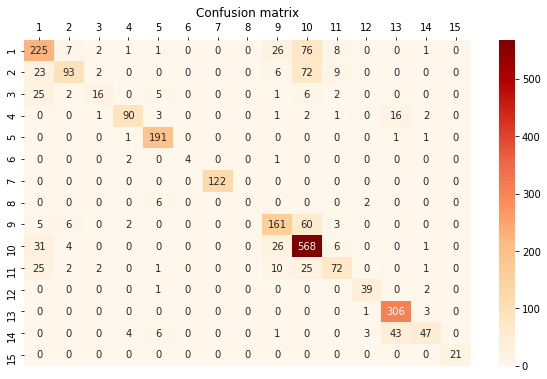

In [28]:
plot_confusion_matrix(y_test_indiana, preds_test, class_names=np.arange(1, 16))

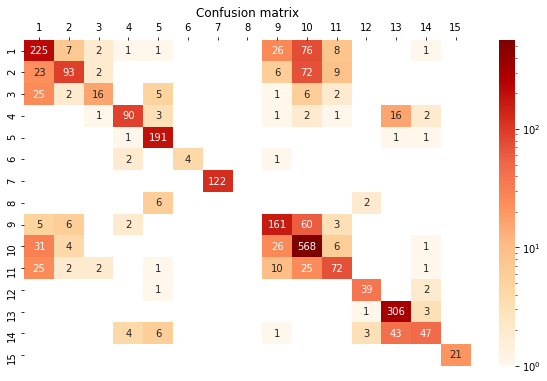

In [29]:
plot_confusion_matrix(y_test_indiana, preds_test, class_names=np.arange(1, 16), log=True)

In [30]:
preds = np.hstack((preds_test, preds_train))

In [31]:
labels = np.hstack((y_test_indiana, y_train_indiana))

In [32]:
pred_img = np.zeros((indiana_img.shape[0] * indiana_img.shape[1]))
pred_img[X_indiana_idx] = preds

In [33]:
labels_img = np.zeros((indiana_img.shape[0] * indiana_img.shape[1]))
labels_img[X_indiana_idx] = labels

In [34]:
pred_img.shape

(21025,)

In [35]:
labels_img.shape

(21025,)

In [36]:
pred_img = pred_img.reshape((indiana_img.shape[0], indiana_img.shape[1]))

In [37]:
labels_img = labels_img.reshape((indiana_img.shape[0], indiana_img.shape[1]))

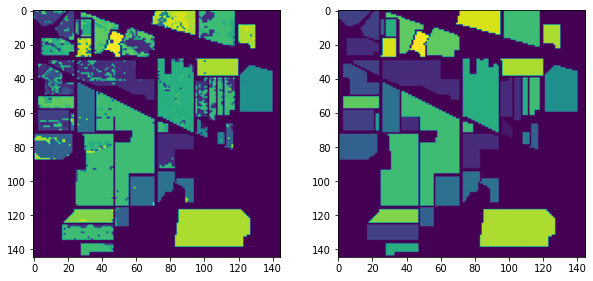

In [38]:
plot_two_figures(pred_img, labels_img)

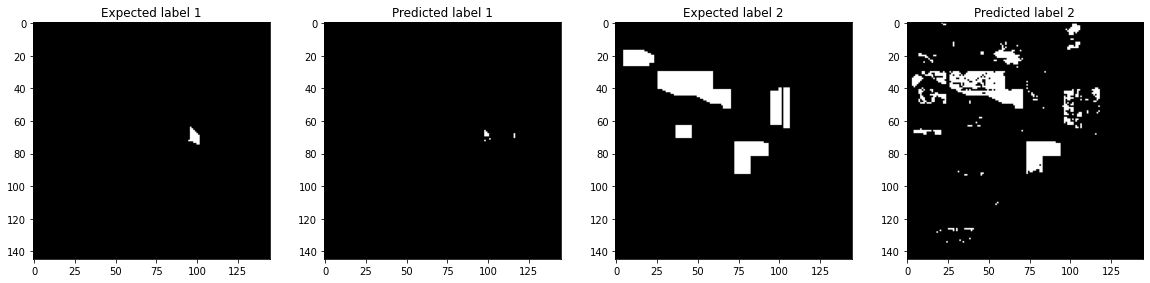

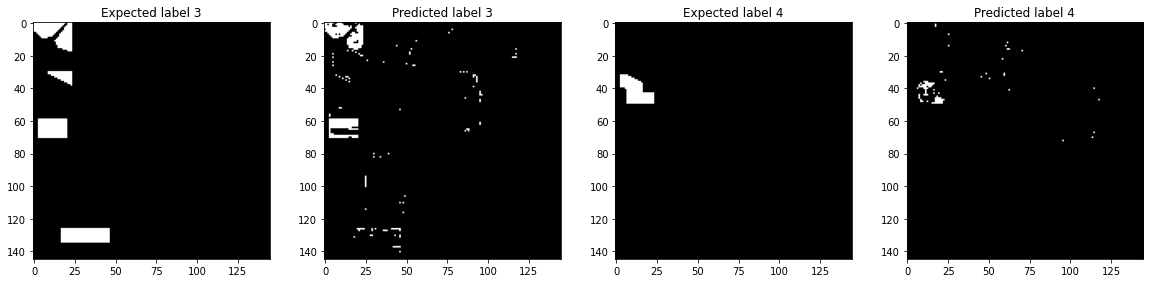

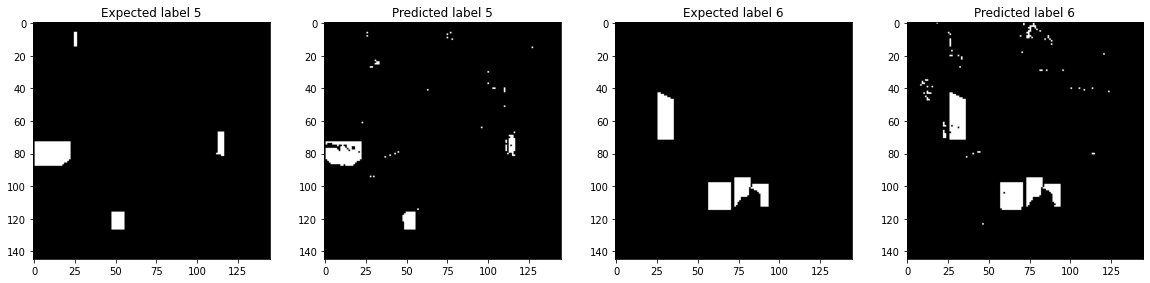

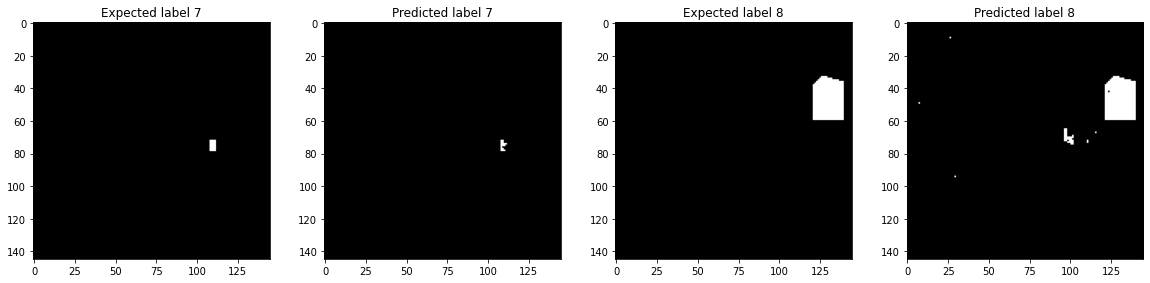

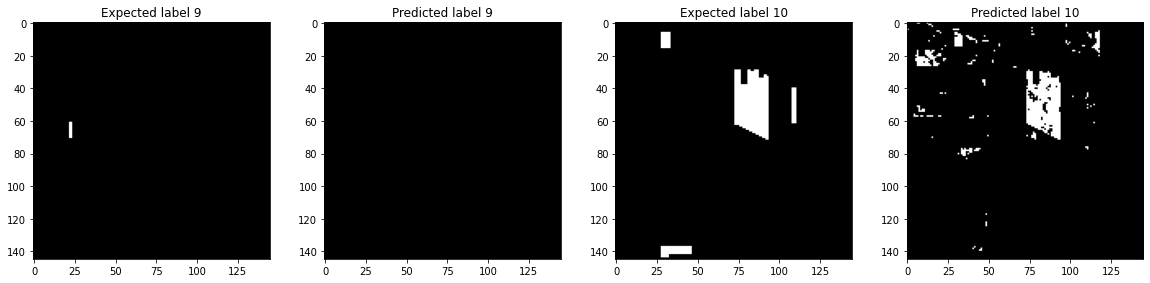

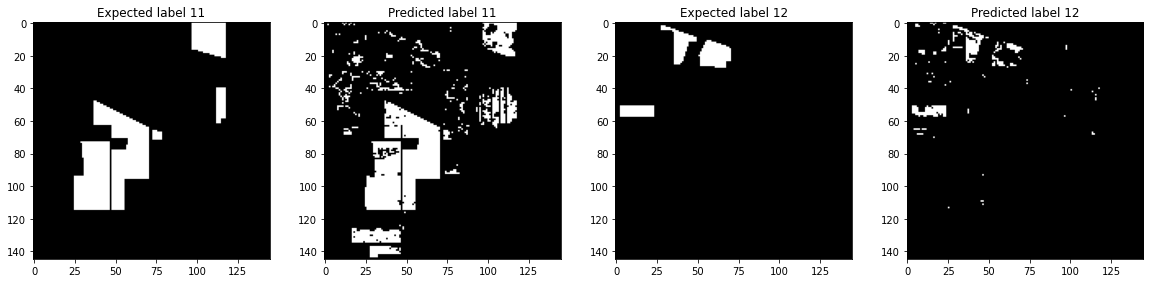

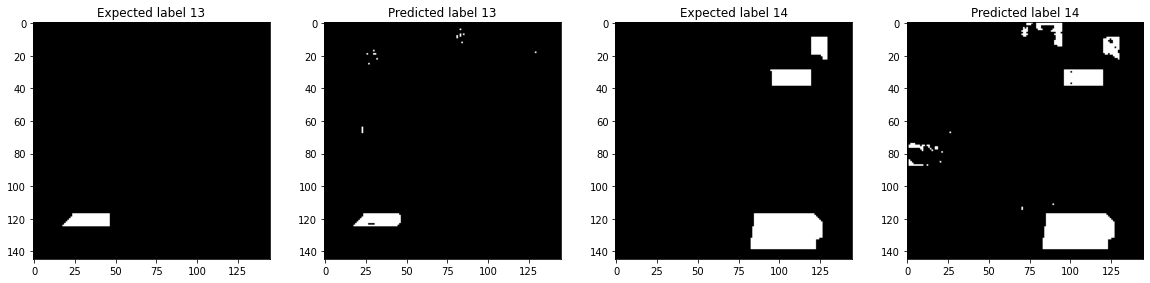

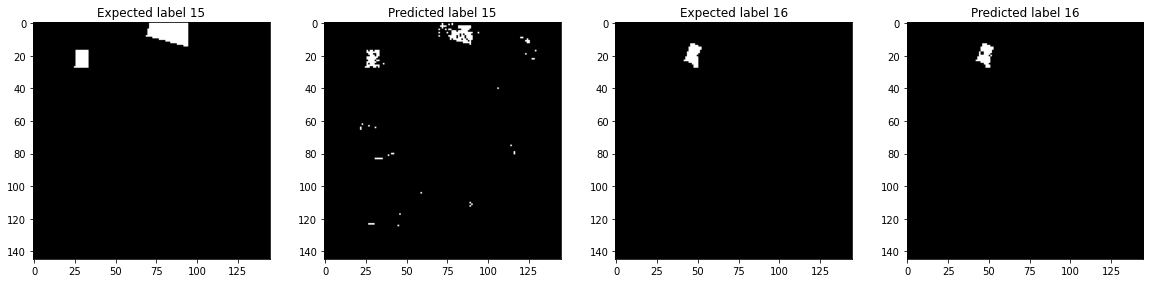

In [39]:
plot_each_labels(labels_img, pred_img, n_cluster_indiana, figsize=(20, 20), cmap='gray')